# Chapter 10 - Model Comparision and Hierarchical Modelling

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from IPython.display import Image
from matplotlib import gridspec

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('seaborn-v0_8-white')

color = '#87ceeb'

In [3]:
%load_ext watermark
%watermark -p matplotlib,numpy,pandas,pymc,seaborn

matplotlib: 3.10.0
numpy     : 1.26.4
pandas    : 2.2.3
pymc      : 5.16.1
seaborn   : 0.13.2



## 10.3.2 - Hierarchical MCMC computation of relative model probability

### Model 1 - One theta variable

In [3]:
with pm.Model() as hierarchical_model:
    # Data
    m = pm.Categorical('m', np.asanyarray([0.5, 0.5]))

    kappa = 12

    omega = pm.math.switch(pm.math.eq(m, 0), 0.25, 0.75)

    theta = pm.Beta(
        'theta',
        omega*(kappa - 2) + 1,
        (1 - omega)*(kappa - 2) + 1
    )

    y = pm.Bernoulli('y', theta, observed = [1, 1, 1, 1, 1, 1, 0, 0, 0])

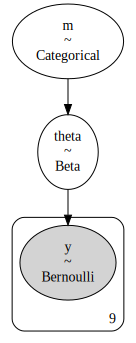

In [4]:
pm.model_to_graphviz(hierarchical_model)

In [5]:
with hierarchical_model:
    idata = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.


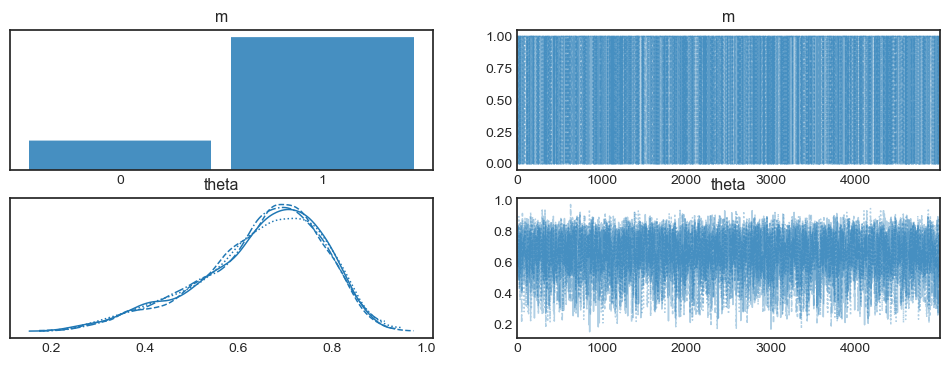

In [6]:
az.plot_trace(idata);

In [7]:
trace_df = (idata
            .posterior
            .to_dataframe()
            .set_index('m')
           )

In [8]:
trace_df.head()

,theta
m,
1,0.699208
1,0.795454
1,0.591230
1,0.588888
1,0.774935


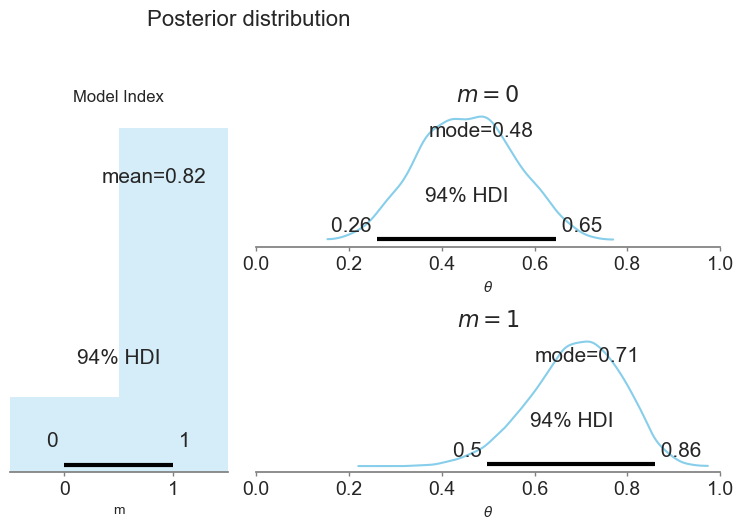

In [9]:
fig = plt.figure(figsize=(10, 5))

font_d = {"size": 16}

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:, 1])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 2:])

# Distplot m
az.plot_posterior(np.asarray(trace_df.index), ax=ax1, color=color)
ax1.set_xlabel("m")
ax1.set_title("Model Index")

# Distplot theta for m=0 and m=1
for model, ax in zip((0, 1), (ax2, ax3)):
    az.plot_posterior(
        trace_df.loc[model].values.ravel(), point_estimate="mode", ax=ax, color=color
    )
    ax.set_title(r"$m = {}$".format(model), fontdict=font_d)
    ax.set(xlim=(0, 1), xlabel=r"$\theta$")

fig.suptitle("Posterior distribution", size=16, y=1.05)

fig.tight_layout()

### Model 2 - Two theta variables without pseudo priors

In [10]:
with pm.Model() as hierarchical_model2:
     # Data
    m = pm.Categorical('m', np.asanyarray([0.5, 0.5]))

    omega_0 = 0.25
    kappa_0 = 12
    theta_0 = pm.Beta(
        'theta_0',
        omega_0 * (kappa_0 - 2) + 1, 
        (1 - omega_0) * (kappa_0 - 2) + 1
    )

    omega_1 = 0.75
    kappa_1 = 12
    theta_1 = pm.Beta(
        "theta_1", omega_1 * (kappa_1 - 2) + 1, (1 - omega_1) * (kappa_1 - 2) + 1
    )

    theta = pm.math.switch(
        pm.math.eq(m, 0),
        theta_0,
        theta_1
    )

    y2 = pm.Bernoulli("y2", theta, observed=[1, 1, 1, 1, 1, 0, 0, 0])

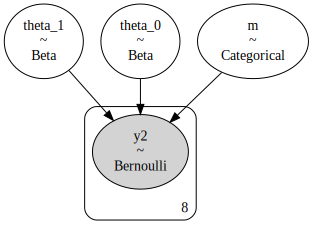

In [11]:
pm.model_to_graphviz(hierarchical_model2)

In [12]:
with hierarchical_model2:
    idata2 = pm.sample(5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [m]
>NUTS: [theta_0, theta_1]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


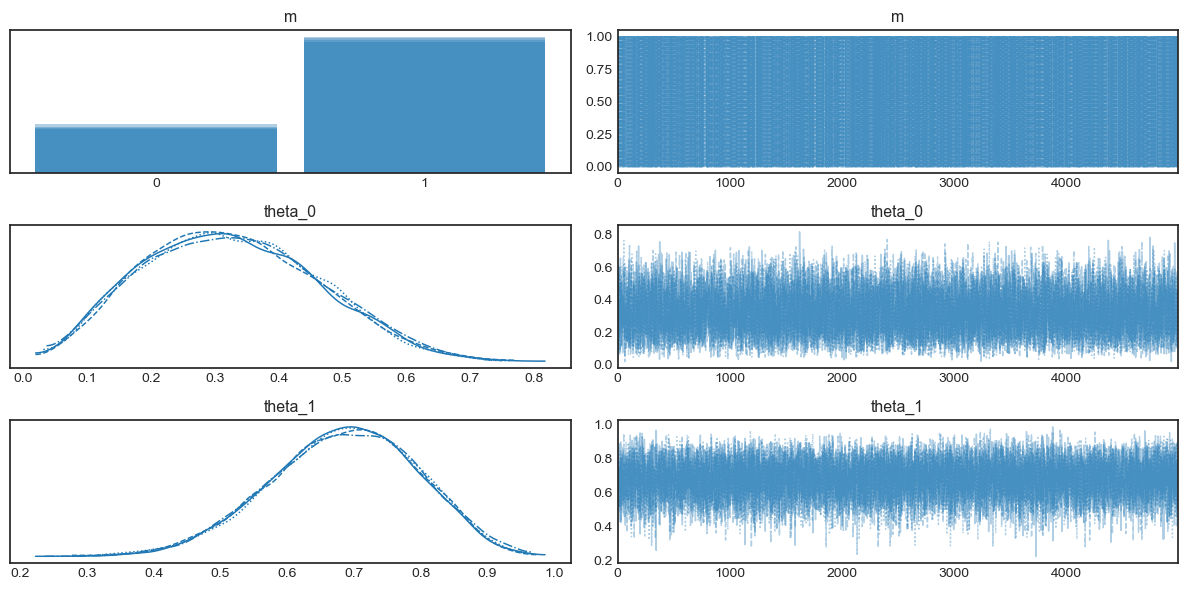

In [13]:
az.plot_trace(idata2)
plt.tight_layout();

### Model 3 - Two theta variables with pseudo priors = true prior

In [14]:
with pm.Model() as hierarchical_model3:
    m = pm.Categorical("m", np.asarray([0.5, 0.5]))

    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 20
    kappa_0 = pm.math.switch(pm.math.eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = 0.10
    omega_0_pseudo_p = 0.10
    omega_0 = pm.math.switch(pm.math.eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta(
        "theta_0", omega_0 * (kappa_0 - 2) + 1, (1 - omega_0) * (kappa_0 - 2) + 1
    )

    # Theta1
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 20
    kappa_1 = pm.math.switch(pm.math.eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = 0.90
    omega_1_pseudo_p = 0.90
    omega_1 = pm.math.switch(pm.math.eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta(
        "theta_1", omega_1 * (kappa_1 - 2) + 1, (1 - omega_1) * (kappa_1 - 2) + 1
    )

    theta = pm.math.switch(pm.math.eq(m, 0), theta_0, theta_1)

    y3 = pm.Bernoulli("y3", theta, observed=np.array(17 * [1] + 13 * [0]))

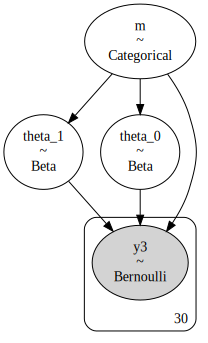

In [15]:
pm.model_to_graphviz(hierarchical_model3)

In [ ]:
with hierarchical_model3:
    idata3 = pm.sample(5000)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_useless_switch
ERROR (pytensor.graph.rewriting.basic): node: Switch(Eq.0, 20, 20)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\Lib\site-packages\pytensor\graph\rewriting\basic.py", line 1081, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bacos1\AppData\Local\anaconda3\envs\per_python_bayes\Lib\site-packages\pytensor\tensor\rewriting\basic.py", line 1026, in local_useless_switch
    copy_stack_trace(node.outputs + node.inputs, left)
  File "C:\Users\bacos1\AppD

In [ ]:
az.plot_trace(idata3)
plt.tight_layout();

In [ ]:
trace3_df = idata3.posterior.to_dataframe().set_index('m')[['theta_0', 'theta_1']]
trace3_df.head()

In [ ]:
fig = plt.figure(figsize=(10, 8))

# Define gridspec
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

az.plot_posterior(np.asarray(trace3_df.index), ax=ax1, color=color)
ax1.set_xlabel("m")
ax1.set_title("Model Index")

for model, theta, ax in zip((0, 0, 1, 1), (0, 1, 0, 1), (ax2, ax3, ax4, ax5)):
    az.plot_posterior(
        trace3_df.loc[model, "theta_{}".format(theta)].values, ax=ax, color=color
    )
    ax.set_title(r"$m = {}$".format(model), fontdict=font_d)
    ax.set_xlim(0, 1)
    ax.set_xlabel(r"$\theta_{}$".format(theta), fontdict=font_d)

fig.tight_layout()

### Model 4 - Two theta variables with pseudo priors that mimic posteriors